In [1]:
import matplotlib.pyplot as plt
import numpy as np
import heapq
import logging
import sys
import time
import math
from capper import Reads
import capper

In [2]:
start_time = time.time()
# Parse the 1kg reads
reads_1kg_small = Reads("minimizers_1kg_single/minimizers_correct",
                  "minimizers_1kg_single/minimizers_incorrect",
              max_correct_reads=10000)
print("Got ", len(reads_1kg_small.reads), " in ", time.time() - start_time, " seconds")

Got  39668  in  32.786685943603516  seconds


In [3]:
start_time = time.time()
# Parse the 1kg reads
reads_1kg_small_cover = Reads("minimizers_1kg_single_cover/minimizers_correct",
                  "minimizers_1kg_single_cover/minimizers_incorrect",
              max_correct_reads=10000)
print("Got ", len(reads_1kg_small_cover.reads), " in ", time.time() - start_time, " seconds")

Got  42606  in  36.73502588272095  seconds


In [4]:
start_time = time.time()
# Parse the hgsvc reads
reads_hgsvc_small = Reads("minimizers_hgsvc_single/minimizers_correct",
                  "minimizers_hgsvc_single/minimizers_incorrect",
              max_correct_reads=10000)
print("Got ", len(reads_hgsvc_small.reads), " in ", time.time() - start_time, " seconds")

Got  66097  in  58.90446400642395  seconds


In [5]:
def current_cap(r):
    return r.capped_map_q  # round(min(r.uncapped_map_q, f(r.xian_cap), r.vg_computed_cap, 60))

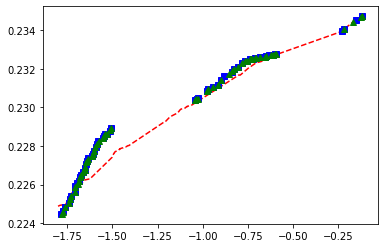

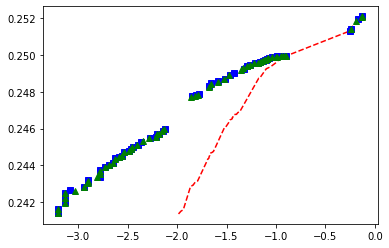

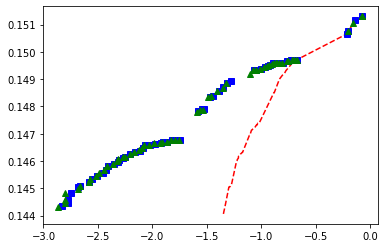

 Took  2.0659399032592773  seconds


In [8]:
## Make the small plots
def add_log(x, y):
    if (x > y):
        return x + math.log(1.0 + math.exp(y - x))
    else:
        return y + math.log(1.0 + math.exp(x - y))

def calc_map_q(r):
    if len(r.alignment_scores) == 0: # Case is unaligned
        return 0.0

    c = 1.38333
    def modified_alignment_score(i):
        alignment_score = r.alignment_scores[i] * c
        m = r.clusters[i][1][1] # Equivalent clusters
        n = r.clusters[i][1][0] # Equivalent clusters kept
        return alignment_score + (math.log(1 + (m - n)/n) if n < m else 0.0)
    
    log_sum_exp = modified_alignment_score(0) 
    for i in range(1,len(r.alignment_scores)): # Add from smallest to largest
        log_sum_exp = add_log(log_sum_exp, modified_alignment_score(i))
    
    max_score = r.alignment_scores[-1] * c

    if max_score == log_sum_exp:
        return 10000

    return -10 * math.log10(1.0 - math.exp(max_score - log_sum_exp))

def proposed_cap(r):
    map_q = calc_map_q(r)
    escape_bonus = 1.0 if map_q < 10000 else 2.0
    return round(min(r.faster_cap_precomputed * escape_bonus, map_q, 60))

def make_rocs(reads):
    # Make ROC curves
    roc_unmodified = reads.get_roc()
    #print("Roc unmodified", roc_unmodified)
    roc_adam_modified = reads.get_roc(map_q_fn=current_cap)
    #print("Roc adam modified ", roc_adam_modified)
    start_time = time.time()
    roc_new_sum_modified = reads.get_roc(map_q_fn=proposed_cap)
    #print("Roc mode modified (time:{}) ".format(time.time()-start_time), roc_new_sum_modified)
    #Reads.plot_rocs([roc_unmodified, roc_adam_modified, roc_new_sum_modified])
    
    Reads.plot_rocs([roc_unmodified, roc_adam_modified, roc_new_sum_modified ])

start_time = time.time()
make_rocs(reads_1kg_small_cover)
make_rocs(reads_1kg_small)
make_rocs(reads_hgsvc_small)
print(" Took ", time.time() - start_time, " seconds")

In [41]:
start_time = time.time()
# Parse the hgsvc reads
reads_hgsvc = Reads("minimizers_hgsvc_single/minimizers_correct",
                    "minimizers_hgsvc_single/minimizers_incorrect",
              max_correct_reads=100000000)
print("Got ", len(reads_hgsvc.reads), " in ", time.time() - start_time, " seconds")

Got  2000000  in  4869.979743242264  seconds


In [42]:
start_time = time.time()
# Parse the 1kg reads
reads_1kg = Reads("minimizers_1kg_single/minimizers_correct",
                  "minimizers_1kg_single/minimizers_incorrect",
              max_correct_reads=100000000)
print("Got ", len(reads_1kg.reads), " in ", time.time() - start_time, " seconds")

Got  2000000  in  7045.926745176315  seconds


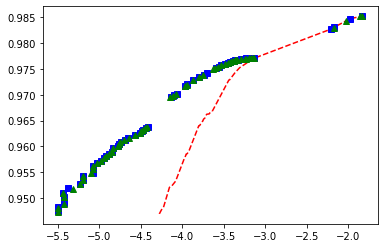

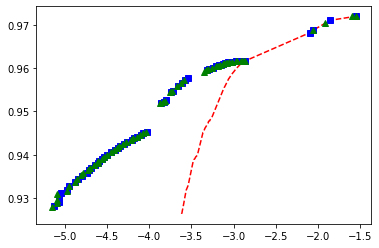

 Took  662.6283977031708  seconds


In [43]:
## Make the big plots

start_time = time.time()
make_rocs(reads_1kg)
make_rocs(reads_hgsvc)
print(" Took ", time.time() - start_time, " seconds")

In [54]:
#  Print some of the funky reads
def print_stages(reads, map_q):
    stages = {}
    total_wrong = 0
    total = 0
    for i, read in enumerate(reads.reads):
        if proposed_cap(read) >= map_q: # and read.stage == "cluster":
            total += 1
            if not read.correct:
                #print(read.unexplored_minimizers_windows(), read.avg_unexplored_minimizers(), proposed_cap(read))
                print("Read {} {}".format(i, read))
                if read.stage not in stages:
                    stages[read.stage] = 0
                stages[read.stage] += 1
                total_wrong += 1
    print("Total", total, "Total wrong", total_wrong, "Wrong stages single end:", stages)
    
print("hgsvc")
print_stages(reads_hgsvc_small, 60)

print("1kg")
print_stages(reads_1kg_small, 60)

print("1kg cover")
print_stages(reads_1kg_small_cover, 60)

hgsvc
Read 5350 Read correct:False alignment_count:2 primary_alignment_score:145.0 alignment_scores:[109.0, 145.0] cluster_scores:[(109.0, [1.0, 1.0, 7.21461]), (145.0, [1.0, 1.0, 125.831])] uncapped_map_q:2147480000.0 vg_computed_cap:169.219 xian_cap:inf faster_cap:84.29375930083214 unique_cap:84.29375930083214 balanced_cap:84.29375930083214 stage: winner
	read_string: TTTTCCATCTCAGTCAAAGTAGCATCCTTCCCTCCCTTCCCCACCCACCCCGCAATTTACCTAGTTCCCTGGCCCCAGGTTCTCTCAGTGCCCACATGAGCAAGACCAGGTGGCTTTATCTTCAAAATAGACCCCGAACCTGTCTGTAAT
	qual_string: 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 10 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 10 6 30 30 30 30 30 30 30 30 30 20 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 4 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 20 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 
 window_start

Read 30115 Read correct:False alignment_count:3 primary_alignment_score:150.0 alignment_scores:[135.0, 135.0, 150.0] cluster_scores:[(135.0, [1.0, 1.0, 102.184]), (135.0, [1.0, 1.0, 102.184]), (150.0, [1.0, 1.0, 102.184])] uncapped_map_q:87.0 vg_computed_cap:90.6983 xian_cap:inf faster_cap:90.75212917717582 unique_cap:90.75212917717582 balanced_cap:90.75212917717582 stage: winner
	read_string: GCTGGCGGGAAAGGCTGGAGGGGTCGGGAAAAGCTGGAGGGGTCGGGAAAGGCTGGAGGGGTCGGGAAAGGCTGGAGGGGTCGGGAAAGGCTGGAGGGGTCGGGAAAGGCTGGAGGGGTCGGGAAAGGCTGGAGGGGTCGGGAAAGGCTG
	qual_string: 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 6 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 20 30 30 30 30 30 30 30 30 30 30 30 20 10 10 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 10 30 30 30 30 30 30 30 30 30 30 30 3

Read 51906 Read correct:False alignment_count:2 primary_alignment_score:145.0 alignment_scores:[120.0, 145.0] cluster_scores:[(120.0, [12.0, 12.0, 15.0198]), (145.0, [1.0, 1.0, 21.7126])] uncapped_map_q:2147480000.0 vg_computed_cap:73.0512 xian_cap:inf faster_cap:36.532002200902184 unique_cap:-0.0 balanced_cap:30.0 stage: cluster
	read_string: GTGGATCACCTGAGGTCGGGAGTTCGAGACCAGCCTGACCAACATGCAGAAACCCCATCTCTACTAAAAATACAAAATTAGCCGGGCATGGTGGTGCATGCCTGTAATCCCAGCTACTCAGGAGGCTGAGACAGGAGAATCGCTTCAACC
	qual_string: 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 20 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 10 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 20 30 
 window_start: 0 window_length: 4 mini

Read 21550 Read correct:False alignment_count:2 primary_alignment_score:155.0 alignment_scores:[29.0, 155.0] cluster_scores:[(29.0, [1.0, 1.0, 5.82831]), (155.0, [1.0, 1.0, 108.629])] uncapped_map_q:2147480000.0 vg_computed_cap:141.603 xian_cap:inf faster_cap:70.68551958126588 unique_cap:70.68551958126588 balanced_cap:70.68551958126588 stage: none
	read_string: GATACACACACCCACACACACACAGATACACCCACACACGCAGACACCCCCCCCCACACACACACACACACATAGATACACGGATACTCACACACACTCACACACACACGTGCCCACACACACAGATACACCCACACAGACACCCACACA
	qual_string: 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 10 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 20 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 10 6 10 30 30 30 30 30 30 30 30 30 30 30 20 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 10 30 30 30 30 30 30 
 window_start: 0 wind


Read 3197 Read correct:False alignment_count:2 primary_alignment_score:150.0 alignment_scores:[135.0, 150.0] cluster_scores:[(135.0, [1.0, 1.0, 88.1869]), (150.0, [1.0, 1.0, 40.4573])] uncapped_map_q:90.0 vg_computed_cap:78.9188 xian_cap:inf faster_cap:78.55227662855356 unique_cap:18.612489327668346 balanced_cap:48.61248932766834 stage: align
	read_string: ACATGGTCACCCTCCCTCCTTCAGCCCATCCATCAGCTCAGCGTTGTGGGGTCCTTACCATGGCAGTCGTCCCTCCAGCCCTGGAGATGCTTCAGGGAAGACCAAGGTCCATGCTGCAGGCAGACTCAGATCAGCAGAGAAGCATCTCGC
	qual_string: 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 20 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 10 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 20 10 20 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 
 window_start: 0 window_


Read 10286 Read correct:False alignment_count:3 primary_alignment_score:155.0 alignment_scores:[131.0, 145.0, 155.0] cluster_scores:[(131.0, [1.0, 1.0, 75.4948]), (145.0, [1.0, 1.0, 106.193]), (155.0, [1.0, 1.0, 76.0908])] uncapped_map_q:60.0 vg_computed_cap:99.1814 xian_cap:inf faster_cap:97.2760028611757 unique_cap:50.74567357334175 balanced_cap:80.74567357334175 stage: align
	read_string: ATACCATACCAATTATTTGTTCTTTGAGACCTTGACACAGTAAGGTTTATATTCTAAATGTATTTTTAGCAATTAAATATCAAATCTAAACCAATTAGTCTAATAGAGGAGACTCGTTCAATCACATGTTTATGTTTTTCTCTCTATGAA
	qual_string: 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 10 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 6 30 30 30 30 30 30 30 30 30 30 30 30


Read 20821 Read correct:False alignment_count:2 primary_alignment_score:160.0 alignment_scores:[150.0, 160.0] cluster_scores:[(150.0, [1.0, 1.0, 101.911]), (160.0, [1.0, 1.0, 109.125])] uncapped_map_q:60.0 vg_computed_cap:81.0707 xian_cap:inf faster_cap:81.28442121119505 unique_cap:67.53540193286716 balanced_cap:81.28442121119505 stage: align
	read_string: GTGTGACTGCGCCCTGCTGTGGGGTCGGAGAGGGTACTGTGGAGCTTCTCGGGCGCAGGACTAGTTGACAGAGTCCAGCTGTGTGCCAGGCAGTGTGTGTCCCCCGTGTGTTTGGTGGCAGGGGTCCCAGCATCCTAGAGTCCAGTCCCC
	qual_string: 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 20 30 10 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 10 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 
 window_start: 0 window_


Read 32238 Read correct:False alignment_count:2 primary_alignment_score:155.0 alignment_scores:[145.0, 155.0] cluster_scores:[(145.0, [1.0, 1.0, 135.956]), (155.0, [1.0, 1.0, 93.3618])] uncapped_map_q:60.0 vg_computed_cap:105.399 xian_cap:inf faster_cap:105.17558881035598 unique_cap:41.66595288491558 balanced_cap:71.66595288491558 stage: align
	read_string: TCCAGTGACTTCAAACAGGGAGATATATTGCCACCACCCCACCCCCTGTGGAGTATTTGGCAATATCTGTAGATGTTTTGGGTTGTCAGGTGTGTGTGTGTTGCGGGGGAGGTGCTAGAAGTATCCAATGGGCAGAGGCCAGGAGTGCTA
	qual_string: 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 10 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 
 window_start: 0 window

In [ ]:
hgsvc
Total 9961 Total wrong 209 Wrong stages single end: {'none': 112, 'extend': 27, 'cluster': 35, 'align': 28, 'winner': 7}
1kg
Total 9909 Total wrong 110 Wrong stages single end: {'extend': 19, 'align': 29, 'cluster': 27, 'none': 35}